# **Supervised Machine Learning - SML**

In [51]:
"""
model_training_02.py

This script uses 3 machine learning models to predict stock movements based on the tweet sentiment.
It conculdes with a backtest of the respective trading strategy.
"""

# Data Handling
import pandas as pd
import numpy as np
import os

# Machine Learning & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Performance Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer,
)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
# Loading data
# Get project root dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct relative paths
merged_sentiment = pd.read_csv(os.path.join(base_dir, "data", "merged_sentiment.csv"))

## Train Test Split

In [6]:
# Extract y values based on stock type
y_net = merged_sentiment[merged_sentiment["stock"] == "netflix"][
    "return_sign"
].to_numpy()
y_am = merged_sentiment[merged_sentiment["stock"] == "amazon"][
    "return_sign"
].to_numpy()

print("y_net:", y_net)
print("y_am:", y_am)

y_net: [0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0]
y_am: [0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0
 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0]


In [7]:
# Train test split netflix
RANDOM_SEED_VAL = 100

x_net = (
    merged_sentiment[merged_sentiment["stock"] == "netflix"]
    .iloc[:, 2:5]
    .to_numpy()
)

x_net_train, x_net_test, y_net_train, y_net_test = train_test_split(
    x_net, y_net, test_size=0.2, shuffle=False, random_state=RANDOM_SEED_VAL
)

In [8]:
# Train test split amazon
x_am = (
    merged_sentiment[merged_sentiment["stock"] == "amazon"]
    .iloc[:, 2:5]
    .to_numpy()
)

x_am_train, x_am_test, y_am_train, y_am_test = train_test_split(
    x_am, y_am, test_size=0.2, shuffle=False, random_state=RANDOM_SEED_VAL
)

In [9]:
print(x_net_train.shape)
print(x_am_train.shape)

print(x_net_test.shape)
print(x_am_test.shape)

(131, 3)
(143, 3)
(33, 3)
(36, 3)


In [10]:
y_net_train = y_net_train.astype(int)
y_net_test = y_net_test.astype(int)
y_am_train = y_am_train.astype(int)
y_am_test = y_am_test.astype(int)

In [11]:
# scaling the data
scaler_netflix = StandardScaler()
scaler_amazon = StandardScaler()

netflix_train_scaled = scaler_netflix.fit_transform(x_net_train)
netflix_test_scaled = scaler_netflix.transform(x_net_test)

amazon_train_scaled = scaler_amazon.fit_transform(x_am_train)
amazon_test_scaled = scaler_amazon.transform(x_am_test)

## The Models (LR, MLP and SVM)

### Logistic Regression

In [12]:
# logistic regression

datasets_scaled = {
    "netflix": (netflix_train_scaled, y_net_train),
    "amazon": (amazon_train_scaled, y_am_train),
}

log_models = {}

for name, (train_scaled, y_train) in datasets_scaled.items():
    model = LogisticRegression(
        C=0.3, class_weight="balanced", random_state=RANDOM_SEED_VAL
    )
    model.fit(train_scaled, y_train)
    log_models[name] = model

# predictions
y_net_pred_lr = log_models["netflix"].predict(netflix_test_scaled)
y_am_pred_lr = log_models["amazon"].predict(amazon_test_scaled)


# Function to evaluate multiple metrics dynamically
def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }


# Define datasets for evaluation
datasets = {
    "Netflix": (y_net_test, y_net_pred_lr),
    "Amazon": (y_am_test, y_am_pred_lr),
}

# Metrics to check
metrics_to_check = ["accuracy", "precision", "recall", "f1"]

# Evaluate all models
for stock, (y_true, y_pred) in datasets.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()}: {results[metric]:.4f}")

Netflix Accuracy: 0.5455
Netflix Precision: 0.6667
Netflix Recall: 0.3333
Netflix F1: 0.4444
Amazon Accuracy: 0.4444
Amazon Precision: 0.3529
Amazon Recall: 0.4000
Amazon F1: 0.3750


### MLP

In [13]:
# Define scaled datasets
datasets_scaled = {
    "netflix": (netflix_train_scaled, y_net_train),
    "amazon": (amazon_train_scaled, y_am_train),
}

mlp_models = {}

# Train MLP models for each dataset
for name, (train_scaled, y_train) in datasets_scaled.items():
    model = MLPClassifier(
        hidden_layer_sizes=(50, 30),
        activation="relu",
        solver="lbfgs",
        alpha=0.001,
        random_state=RANDOM_SEED_VAL,
        max_iter=3000,
    )
    model.fit(train_scaled, y_train)
    mlp_models[name] = model

# Predictions
y_net_pred_mlp = mlp_models["netflix"].predict(netflix_test_scaled)
y_am_pred_mlp = mlp_models["amazon"].predict(amazon_test_scaled)


# Evaluation function
def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }


# Define test sets
datasets = {
    "Netflix": (y_net_test, y_net_pred_mlp),
    "Amazon": (y_am_test, y_am_pred_mlp),
}

metrics_to_check = ["accuracy", "precision", "recall", "f1"]

# Evaluate all models
for stock, (y_true, y_pred) in datasets.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()}: {results[metric]:.4f}")

Netflix Accuracy: 0.4545
Netflix Precision: 0.5000
Netflix Recall: 0.6667
Netflix F1: 0.5714
Amazon Accuracy: 0.6111
Amazon Precision: 0.5200
Amazon Recall: 0.8667
Amazon F1: 0.6500


### SVM

In [14]:
# Define scaled datasets
datasets_scaled = {
    "netflix": (netflix_train_scaled, y_net_train),
    "amazon": (amazon_train_scaled, y_am_train),
}

svm_models = {}

# Train SVM models for each dataset
for name, (train_scaled, y_train) in datasets_scaled.items():
    model = SVC(C=1.0, kernel="rbf", class_weight="balanced", random_state=RANDOM_SEED_VAL)
    model.fit(train_scaled, y_train)
    svm_models[name] = model

# Predictions
y_net_pred_svm = svm_models["netflix"].predict(netflix_test_scaled)
y_am_pred_svm = svm_models["amazon"].predict(amazon_test_scaled)


# Evaluation function
def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }


# Define test sets
datasets = {
    "Netflix": (y_net_test, y_net_pred_svm),
    "Amazon": (y_am_test, y_am_pred_svm),
}

metrics_to_check = ["accuracy", "precision", "recall", "f1"]

# Evaluate all models
for stock, (y_true, y_pred) in datasets.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()}: {results[metric]:.4f}")

Netflix Accuracy: 0.4242
Netflix Precision: 0.4706
Netflix Recall: 0.4444
Netflix F1: 0.4571
Amazon Accuracy: 0.5000
Amazon Precision: 0.4400
Amazon Recall: 0.7333
Amazon F1: 0.5500


### Model Performance Comparison - Plots

In [15]:
# Model performance on training set
# Compute accuracy for each model
train_accuracy = np.array(
    [
        accuracy_score(
            y_net_train, log_models["netflix"].predict(netflix_train_scaled)
        ),
        accuracy_score(
            y_net_train, mlp_models["netflix"].predict(netflix_train_scaled)
        ),
        accuracy_score(
            y_net_train, svm_models["netflix"].predict(netflix_train_scaled)
        ),
        accuracy_score(
            y_am_train, log_models["amazon"].predict(amazon_train_scaled)
        ),
        accuracy_score(
            y_am_train, mlp_models["amazon"].predict(amazon_train_scaled)
        ),
        accuracy_score(
            y_am_train, svm_models["amazon"].predict(amazon_train_scaled)
        ),
    ]
)

# Compute recall for each model
train_recall = np.array(
    [
        recall_score(
            y_net_train, log_models["netflix"].predict(netflix_train_scaled)
        ),
        recall_score(
            y_net_train, mlp_models["netflix"].predict(netflix_train_scaled)
        ),
        recall_score(
            y_net_train, svm_models["netflix"].predict(netflix_train_scaled)
        ),
        recall_score(
            y_am_train, log_models["amazon"].predict(amazon_train_scaled)
        ),
        recall_score(
            y_am_train, mlp_models["amazon"].predict(amazon_train_scaled)
        ),
        recall_score(
            y_am_train, svm_models["amazon"].predict(amazon_train_scaled)
        ),
    ]
)

# Compute precision for each model
train_precision = np.array(
    [
        precision_score(
            y_net_train, log_models["netflix"].predict(netflix_train_scaled)
        ),
        precision_score(
            y_net_train, mlp_models["netflix"].predict(netflix_train_scaled)
        ),
        precision_score(
            y_net_train, svm_models["netflix"].predict(netflix_train_scaled)
        ),
        precision_score(
            y_am_train, log_models["amazon"].predict(amazon_train_scaled)
        ),
        precision_score(
            y_am_train, mlp_models["amazon"].predict(amazon_train_scaled)
        ),
        precision_score(
            y_am_train, svm_models["amazon"].predict(amazon_train_scaled)
        ),
    ]
)

# Compute F1-score for each model
train_f1 = np.array(
    [
        f1_score(
            y_net_train, log_models["netflix"].predict(netflix_train_scaled)
        ),
        f1_score(
            y_net_train, mlp_models["netflix"].predict(netflix_train_scaled)
        ),
        f1_score(
            y_net_train, svm_models["netflix"].predict(netflix_train_scaled)
        ),
        f1_score(
            y_am_train, log_models["amazon"].predict(amazon_train_scaled)
        ),
        f1_score(
            y_am_train, mlp_models["amazon"].predict(amazon_train_scaled)
        ),
        f1_score(
            y_am_train, svm_models["amazon"].predict(amazon_train_scaled)
        ),
    ]
)

# Store results in DataFrame
df_train_performance = pd.DataFrame(
    [train_accuracy, train_recall, train_precision, train_f1]
).T
df_train_performance.columns = ["Accuracy", "Recall", "Precision", "F1-score"]

# Labels for models & datasets
df_train_performance.index = [
    "LG-Netflix",
    "MLP-Netflix",
    "SVM-Netflix",
    "LG-Amazon",
    "MLP-Amazon",
    "SVM-Amazon",
]

# Display results
df_train_performance.head(6)

,Accuracy,Recall,Precision,F1-score
LG-Netflix,0.503817,0.471429,0.540984,0.503817
MLP-Netflix,0.725191,0.785714,0.723684,0.753425
SVM-Netflix,0.618321,0.471429,0.717391,0.568966
LG-Amazon,0.524476,0.448718,0.583333,0.507246
MLP-Amazon,0.748252,0.871795,0.723404,0.790698
SVM-Amazon,0.643357,0.666667,0.675325,0.670968


In [16]:
# Model performance on test set
# Compute accuracy for each model
met_accuracy = np.array(
    [
        accuracy_score(y_net_test, y_net_pred_lr),
        accuracy_score(y_net_test, y_net_pred_mlp),
        accuracy_score(y_net_test, y_net_pred_svm),
        accuracy_score(y_am_test, y_am_pred_lr),
        accuracy_score(y_am_test, y_am_pred_mlp),
        accuracy_score(y_am_test, y_am_pred_svm),
    ]
)

# Compute recall for each model
met_recall = np.array(
    [
        recall_score(y_net_test, y_net_pred_lr),
        recall_score(y_net_test, y_net_pred_mlp),
        recall_score(y_net_test, y_net_pred_svm),
        recall_score(y_am_test, y_am_pred_lr),
        recall_score(y_am_test, y_am_pred_mlp),
        recall_score(y_am_test, y_am_pred_svm),
    ]
)

# Compute precision for each model
met_precision = np.array(
    [
        precision_score(y_net_test, y_net_pred_lr),
        precision_score(y_net_test, y_net_pred_mlp),
        precision_score(y_net_test, y_net_pred_svm),
        precision_score(y_am_test, y_am_pred_lr),
        precision_score(y_am_test, y_am_pred_mlp),
        precision_score(y_am_test, y_am_pred_svm),
    ]
)

# Compute f1 for each model
met_f1 = np.array(
    [
        f1_score(y_net_test, y_net_pred_lr),
        f1_score(y_net_test, y_net_pred_mlp),
        f1_score(y_net_test, y_net_pred_svm),
        f1_score(y_am_test, y_am_pred_lr),
        f1_score(y_am_test, y_am_pred_mlp),
        f1_score(y_am_test, y_am_pred_svm),
    ]
)

# Store results in DataFrame
df_performance = pd.DataFrame(
    [met_accuracy, met_recall, met_precision, met_f1]
).T
df_performance.columns = ["Accuracy", "Recall", "Precision", "f1"]

# Correct labels for models & datasets
df_performance.index = [
    "LG-Netflix",
    "MLP-Netflix",
    "SVM-Netflix",
    "LG-Amazon",
    "MLP-Amazon",
    "SVM-Amazon",
]

# Display results
df_performance.head(6)

,Accuracy,Recall,Precision,f1
LG-Netflix,0.545455,0.333333,0.666667,0.444444
MLP-Netflix,0.454545,0.666667,0.500000,0.571429
SVM-Netflix,0.424242,0.444444,0.470588,0.457143
LG-Amazon,0.444444,0.400000,0.352941,0.375000
MLP-Amazon,0.611111,0.866667,0.520000,0.650000
SVM-Amazon,0.500000,0.733333,0.440000,0.550000


<Figure size 1000x600 with 0 Axes>

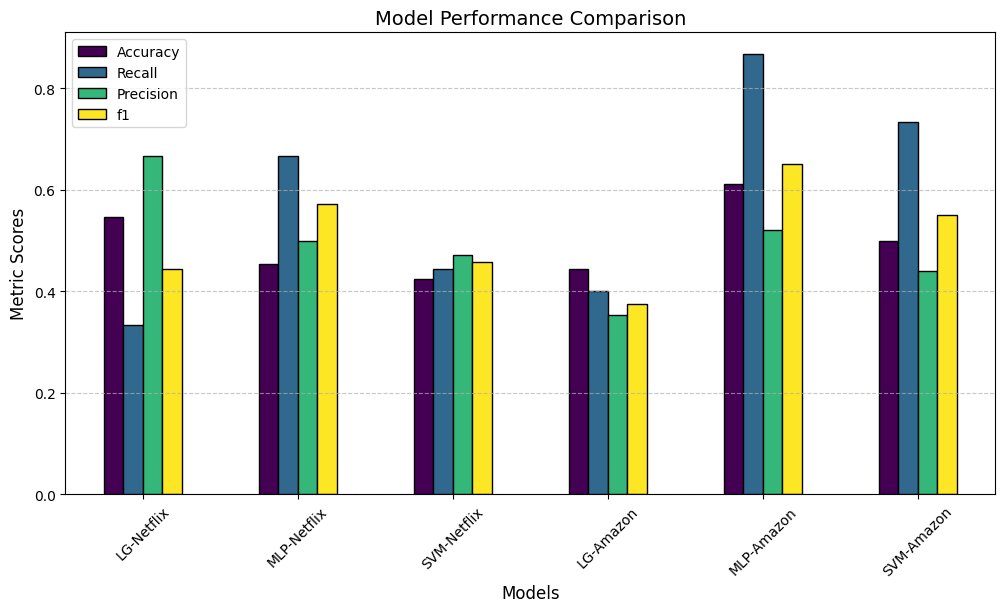

In [17]:
# Plot comparison
plt.figure(figsize=(10, 6))
df_performance.plot(
    kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black"
)

plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Metric Scores", fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc="best", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

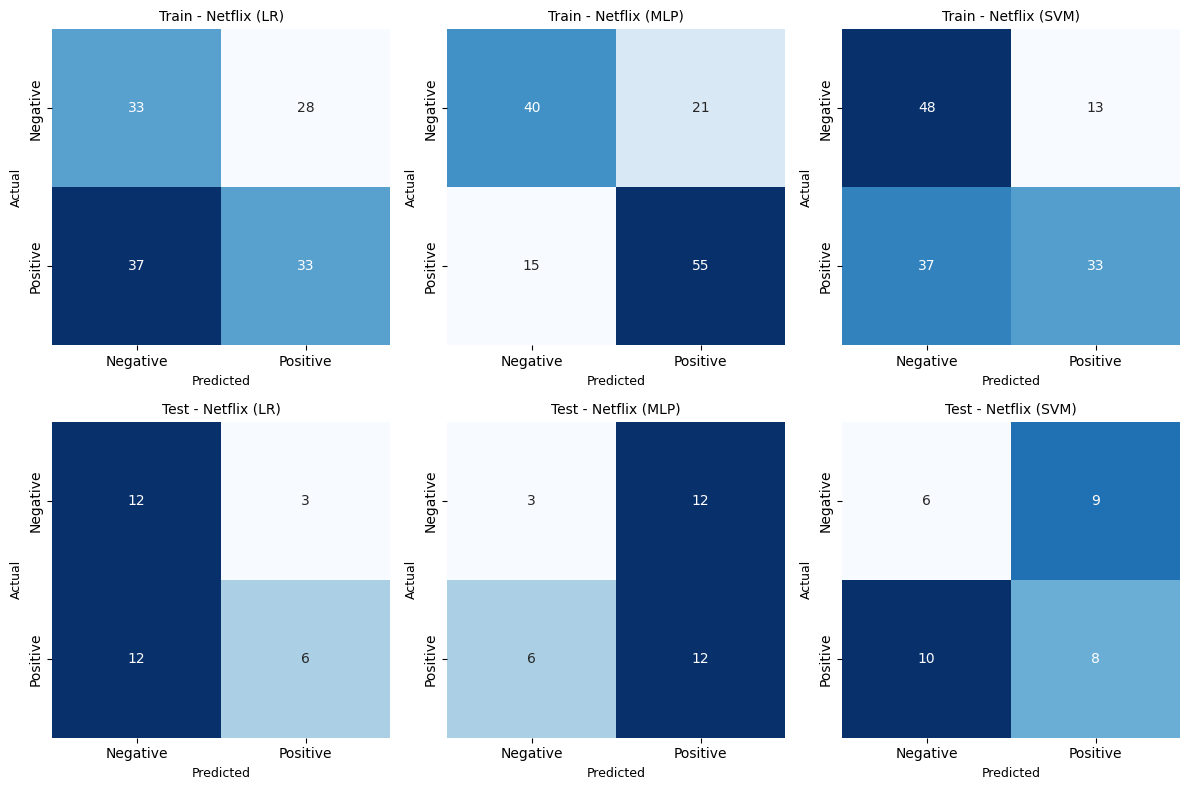

In [18]:
# Function to plot confusion matrix
def plot_conf_matrix(ax, y_true, y_pred, title):
    """
    Plots a confusion matrix heatmap for given true and predicted labels.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The subplot axis to plot the heatmap on.
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        title (str): The title of the plot.

    Returns:
        None
    """
    con_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        con_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
        ax=ax,
    )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Predicted", fontsize=9)
    ax.set_ylabel("Actual", fontsize=9)


# Create figure with multiple subplots
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8)
)  # Adjusted size for compact view

# Train set matrices
plot_conf_matrix(
    axes[0, 0],
    y_net_train,
    log_models["netflix"].predict(netflix_train_scaled),
    "Train - Netflix (LR)",
)
plot_conf_matrix(
    axes[0, 1],
    y_net_train,
    mlp_models["netflix"].predict(netflix_train_scaled),
    "Train - Netflix (MLP)",
)
plot_conf_matrix(
    axes[0, 2],
    y_net_train,
    svm_models["netflix"].predict(netflix_train_scaled),
    "Train - Netflix (SVM)",
)

# Test set matrices
plot_conf_matrix(axes[1, 0], y_net_test, y_net_pred_lr, "Test - Netflix (LR)")
plot_conf_matrix(
    axes[1, 1], y_net_test, y_net_pred_mlp, "Test - Netflix (MLP)"
)
plot_conf_matrix(
    axes[1, 2], y_net_test, y_net_pred_svm, "Test - Netflix (SVM)"
)

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

# Hyper-Parameter Tuning

### Logistic Regression

In [19]:
# Define scorer (optimize for F1-score due to slight class imbalance)
scorer = make_scorer(f1_score)

# Define smaller, optimized parameter grid
parameter_space_lr = {
    "penalty": ["l1", "l2"],
    "C": [0.05, 0.1, 1, 10],
    "solver": ["liblinear"],
    "max_iter": [200, 500],
}

# Run GridSearch for both datasets
best_params_lr = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    print(f"Running GridSearchCV for {dataset_name}...")

    lr_tune = LogisticRegression(random_state=100)
    GSCV_lr = GridSearchCV(
        lr_tune, parameter_space_lr, n_jobs=-1, cv=3, scoring=scorer
    )

    GSCV_lr.fit(train_scaled, y_train)

    best_params_lr[dataset_name] = GSCV_lr.best_params_
    print(f"Best Parameters for {dataset_name}: {GSCV_lr.best_params_}")

# Store results in DataFrame for easy comparison
df_best_params_lr = pd.DataFrame(best_params_lr).T
df_best_params_lr

Running GridSearchCV for netflix...
Best Parameters for netflix: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Running GridSearchCV for amazon...
Best Parameters for amazon: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}


,C,max_iter,penalty,solver
netflix,0.1,200,l2,liblinear
amazon,0.1,200,l2,liblinear


In [20]:
# Train Logistic Regression models with dataset-specific best parameters
optimized_lr_models = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    # Retrieve best parameters for this specific dataset
    best_params = best_params_lr[dataset_name]
    
    # Train the model using the dataset-specific best parameters
    model = LogisticRegression(
        penalty=best_params["penalty"],
        C=best_params["C"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        random_state=RANDOM_SEED_VAL
    )
    model.fit(train_scaled, y_train)
    optimized_lr_models[dataset_name] = model

# Generate predictions for Netflix and Amazon
threshold = 0.51  # Adjust threshold for precision vs recall balance

# Predictions for Netflix
y_net_pred_probs = optimized_lr_models["netflix"].predict_proba(netflix_test_scaled)
y_net_pred_lr_opt = (y_net_pred_probs[:, 1] > threshold).astype(int)

# Predictions for Amazon
y_am_pred_probs = optimized_lr_models["amazon"].predict_proba(amazon_test_scaled)
y_am_pred_lr_opt = (y_am_pred_probs[:, 1] > threshold).astype(int)

# Evaluate the optimized models
datasets_opt_lr = {
    "netflix": (y_net_test, y_net_pred_lr_opt),
    "amazon": (y_am_test, y_am_pred_lr_opt),
}

metrics_to_check = ["accuracy", "precision", "recall", "f1"]

# Print evaluation results
for stock, (y_true, y_pred) in datasets_opt_lr.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()} (Optimized Logistic Regression): {results[metric]:.4f}")

netflix Accuracy (Optimized Logistic Regression): 0.4848
netflix Precision (Optimized Logistic Regression): 0.5333
netflix Recall (Optimized Logistic Regression): 0.4444
netflix F1 (Optimized Logistic Regression): 0.4848
amazon Accuracy (Optimized Logistic Regression): 0.4722
amazon Precision (Optimized Logistic Regression): 0.4375
amazon Recall (Optimized Logistic Regression): 0.9333
amazon F1 (Optimized Logistic Regression): 0.5957


### MLP

In [21]:
# Define scorer
scorer = make_scorer(f1_score)

# Define parameter grid
parameter_space_mlp = {
    "hidden_layer_sizes": [(50,), (100,)],
    "activation": ["relu"],
    "solver": ["adam", "sgd"],
    "alpha": [0.01, 0.02],
    "learning_rate": ["adaptive"],
    "max_iter": [2000, 3000],
}

# Run GridSearch for both datasets
best_params_mlp = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    print(f"Running GridSearchCV for {dataset_name}...")

    mlp_tune = MLPClassifier(random_state=RANDOM_SEED_VAL)
    GSCV_mlp = GridSearchCV(
        mlp_tune, parameter_space_mlp, n_jobs=-1, cv=3, scoring=scorer
    )

    GSCV_mlp.fit(train_scaled, y_train)

    # Store MLP best parameters in the correct dictionary
    best_params_mlp[dataset_name] = GSCV_mlp.best_params_
    print(f"Best Parameters for {dataset_name}: {GSCV_mlp.best_params_}")

# Store results in a DataFrame for easy comparison
df_best_params_mlp = pd.DataFrame(best_params_mlp).T
df_best_params_mlp

Running GridSearchCV for netflix...
Best Parameters for netflix: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}
Running GridSearchCV for amazon...
Best Parameters for amazon: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}


,activation,alpha,hidden_layer_sizes,learning_rate,max_iter,solver
netflix,relu,0.01,"(100,)",adaptive,2000,sgd
amazon,relu,0.01,"(50,)",adaptive,2000,sgd


In [22]:
# Train MLP models with dataset-specific best parameters
optimized_mlp_models = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    # Retrieve the best parameters for the current dataset
    best_params_for_dataset = best_params_mlp[dataset_name]
    
    # Train the model using the best parameters
    model = MLPClassifier(
        activation=best_params_for_dataset["activation"],
        alpha=best_params_for_dataset["alpha"],
        hidden_layer_sizes=best_params_for_dataset["hidden_layer_sizes"],
        learning_rate=best_params_for_dataset["learning_rate"],
        max_iter=best_params_for_dataset["max_iter"],
        solver=best_params_for_dataset["solver"],
        random_state=RANDOM_SEED_VAL  # Keep this consistent for reproducibility
    )
    model.fit(train_scaled, y_train)
    optimized_mlp_models[dataset_name] = model

# Generate predictions for Netflix and Amazon
y_net_pred_mlp_opt = optimized_mlp_models["netflix"].predict(netflix_test_scaled)
y_am_pred_mlp_opt = optimized_mlp_models["amazon"].predict(amazon_test_scaled)

# Evaluate the optimized models
datasets_opt = {
    "netflix": (y_net_test, y_net_pred_mlp_opt),
    "amazon": (y_am_test, y_am_pred_mlp_opt),
}

metrics_to_check = ["accuracy", "precision", "recall", "f1"]

for stock, (y_true, y_pred) in datasets_opt.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()} (Optimized): {results[metric]:.4f}")

netflix Accuracy (Optimized): 0.5152
netflix Precision (Optimized): 0.5417
netflix Recall (Optimized): 0.7222
netflix F1 (Optimized): 0.6190
amazon Accuracy (Optimized): 0.4444
amazon Precision (Optimized): 0.4194
amazon Recall (Optimized): 0.8667
amazon F1 (Optimized): 0.5652


### SVM

In [23]:
# Define scorer (optimize for F1-score due to slight class imbalance)
scorer = make_scorer(f1_score)

# Define optimized parameter grid for SVM
parameter_space_svm = {
    "C": [0.1, 1, 0.2, 10],  # Regularization strength
    "kernel": ["poly"],
    "gamma": [
        "scale",
        "auto",
    ],  # Kernel coefficient (affects non-linear models)
    "class_weight": ["balanced"],  # Adjusts for imbalanced datasets
}

# Run GridSearch for both datasets
best_params_svm = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    print(f"Running GridSearchCV for {dataset_name}...")

    svm_tune = SVC(random_state=RANDOM_SEED_VAL)
    GSCV_svm = GridSearchCV(
        svm_tune, parameter_space_svm, n_jobs=-1, cv=3, scoring=scorer
    )

    GSCV_svm.fit(train_scaled, y_train)

    best_params_svm[dataset_name] = GSCV_svm.best_params_
    print(f"Best Parameters for {dataset_name}: {GSCV_svm.best_params_}")

# Store results in DataFrame for easy comparison
df_best_params_svm = pd.DataFrame(best_params_svm).T
df_best_params_svm

Running GridSearchCV for netflix...
Best Parameters for netflix: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}
Running GridSearchCV for amazon...
Best Parameters for amazon: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}


,C,class_weight,gamma,kernel
netflix,1,balanced,scale,poly
amazon,0.1,balanced,scale,poly


In [24]:
# Train SVM models with dataset-specific best parameters
optimized_svm_models = {}

for dataset_name, (train_scaled, y_train) in datasets_scaled.items():
    # Retrieve the best parameters for the current dataset
    best_params_for_dataset = best_params_svm[dataset_name]
    
    # Train the model using the best parameters
    model = SVC(
        C=best_params_for_dataset["C"],
        kernel=best_params_for_dataset["kernel"],
        gamma=best_params_for_dataset["gamma"],
        class_weight=best_params_for_dataset["class_weight"],
        probability=True,  # Ensure probability is enabled for prediction
        random_state=RANDOM_SEED_VAL
    )
    model.fit(train_scaled, y_train)
    optimized_svm_models[dataset_name] = model

# Generate predictions for Netflix and Amazon
threshold = 0.48  # Adjust this as needed

# Get prediction probabilities
y_net_pred_probs = optimized_svm_models["netflix"].predict_proba(netflix_test_scaled)
y_am_pred_probs = optimized_svm_models["amazon"].predict_proba(amazon_test_scaled)

# Apply thresholding
y_net_pred_svm_opt = (y_net_pred_probs[:, 1] > threshold).astype(int)
y_am_pred_svm_opt = (y_am_pred_probs[:, 1] > threshold).astype(int)

# Evaluate the optimized model
datasets_opt_svm = {
    "netflix": (y_net_test, y_net_pred_svm_opt),
    "amazon": (y_am_test, y_am_pred_svm_opt),
}

metrics_to_check = ["accuracy", "precision", "recall", "f1"]

# Print optimized evaluation results
for stock, (y_true, y_pred) in datasets_opt_svm.items():
    results = evaluate_model(y_true, y_pred)
    for metric in metrics_to_check:
        print(f"{stock} {metric.capitalize()} (Optimized SVM): {results[metric]:.4f}")

netflix Accuracy (Optimized SVM): 0.4848
netflix Precision (Optimized SVM): 0.5161
netflix Recall (Optimized SVM): 0.8889
netflix F1 (Optimized SVM): 0.6531
amazon Accuracy (Optimized SVM): 0.3889
amazon Precision (Optimized SVM): 0.4000
amazon Recall (Optimized SVM): 0.9333
amazon F1 (Optimized SVM): 0.5600


In [29]:
# Initialize list to store results dynamically
metrics_results = []

# Define datasets containing previously computed results
datasets_opt_all = {
    "SVM": datasets_opt_svm,  # Contains optimized SVM results
    "LR": datasets_opt_lr,  # Contains optimized LR results
    "MLP": datasets_opt,  # Contains optimized MLP results
}

# Loop through each model type and stock
for model_name, dataset in datasets_opt_all.items():
    for stock, (y_true, y_pred) in dataset.items():
        results = evaluate_model(
            y_true, y_pred
        )  # Pull previously computed metrics

        # Store results dynamically
        metrics_results.append(
            {
                "Model": model_name,
                "Stock": stock,
                **{
                    metric: results[metric]
                    for metric in ["accuracy", "precision", "recall", "f1"]
                },
            }
        )

# Convert list into DataFrame
df_metrics = pd.DataFrame(metrics_results)

# New column combining Model and Stock for x-axis labels
df_metrics["Model_Stock"] = df_metrics["Model"] + " - " + df_metrics["Stock"]

# Display consolidated metrics
df_metrics

,Model,Stock,accuracy,precision,recall,f1,Model_Stock
0,SVM,netflix,0.484848,0.516129,0.888889,0.653061,SVM - netflix
1,SVM,amazon,0.388889,0.400000,0.933333,0.560000,SVM - amazon
2,LR,netflix,0.484848,0.533333,0.444444,0.484848,LR - netflix
3,LR,amazon,0.472222,0.437500,0.933333,0.595745,LR - amazon
4,MLP,netflix,0.515152,0.541667,0.722222,0.619048,MLP - netflix
5,MLP,amazon,0.444444,0.419355,0.866667,0.565217,MLP - amazon


<Figure size 800x400 with 0 Axes>

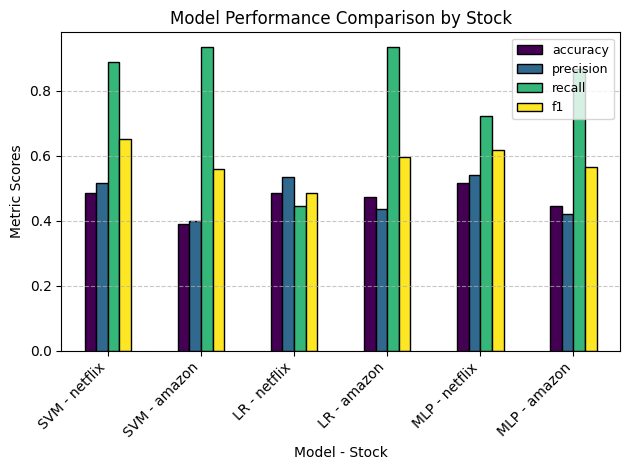

In [105]:
# Set the index to the combined label
df_plot = df_metrics.set_index("Model_Stock")[["accuracy", "precision", "recall", "f1"]]

# Plot comparison
plt.figure(figsize=(8, 4))
df_plot.plot(
    kind="bar",
    colormap="viridis",
    edgecolor="black",
)

plt.title("Model Performance Comparison by Stock", fontsize=12)
plt.xlabel("Model - Stock", fontsize=10)
plt.ylabel("Metric Scores", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the figure
plt.savefig("images/model_performance.png", bbox_inches="tight", dpi=300)
plt.show()


#  **Trading Strategy**

In [35]:
# Get the best model for each stock based on highest precision
best_netflix_model_name = (
    df_metrics[df_metrics["Stock"] == "netflix"]
    .sort_values(by="precision", ascending=False)
    .iloc[0]["Model"]
)
best_amazon_model_name = (
    df_metrics[df_metrics["Stock"] == "amazon"]
    .sort_values(by="precision", ascending=False)
    .iloc[0]["Model"]
)

print(f"Best Model for Netflix: {best_netflix_model_name}")
print(f"Best Model for Amazon: {best_amazon_model_name}")

# Retrieve predictions from the selected models
netflix_predictions = datasets_opt_all[best_netflix_model_name]["netflix"][1]
amazon_predictions = datasets_opt_all[best_amazon_model_name]["amazon"][1]

# Apply trading rules based on predictions
trade_threshold = 0.50  # Adjust if necessary
netflix_trades = [
    "BUY" if pred > trade_threshold else "SELL" for pred in netflix_predictions
]
amazon_trades = [
    "BUY" if pred > trade_threshold else "SELL" for pred in amazon_predictions
]

# Filter sentiment data separately to match test set sizes
merged_sentiment_netflix = merged_sentiment[
    merged_sentiment["stock"] == "netflix"
].tail(len(netflix_trades))
merged_sentiment_amazon = merged_sentiment[
    merged_sentiment["stock"] == "amazon"
].tail(len(amazon_trades))

# Create separate DataFrames
df_netflix_strategy = pd.DataFrame(
    {"Date": merged_sentiment_netflix["date"], "Netflix Trade": netflix_trades}
)

df_amazon_strategy = pd.DataFrame(
    {"Date": merged_sentiment_amazon["date"], "Amazon Trade": amazon_trades}
)

Best Model for Netflix: MLP
Best Model for Amazon: LR


## Amazon Trading Strategy

In [36]:
# Merge the pred data frame with histdata which contains the level of returns

amazon_returns = merged_sentiment[merged_sentiment["stock"] == "amazon"][
    ["returns", "date"]
]
amazon_returns.rename(columns={"date": "Date"}, inplace=True)

amazon_backtest = df_amazon_strategy.merge(
    amazon_returns, on="Date", how="left"
)

In [37]:
# Buy and hold returns
amazon_backtest["buyandhold"] = (amazon_backtest["returns"] + 1).cumprod()

# Map trade actions to numeric values
amazon_backtest["strategy_multiplier"] = amazon_backtest["Amazon Trade"].map(
    {"BUY": 1, "SELL": -1}
)

# Apply strategy returns calculation
amazon_backtest["strategy_return"] = (
    amazon_backtest["strategy_multiplier"] * amazon_backtest["returns"]
)

# Calculate cumulative strategy return
amazon_backtest["strategy_cumulative"] = (
    amazon_backtest["strategy_return"] + 1
).cumprod()

amazon_backtest

,Date,Amazon Trade,returns,buyandhold,strategy_multiplier,strategy_return,strategy_cumulative
0,2025-01-29,SELL,-0.004535,0.995465,-1,0.004535,1.004535
1,2025-01-31,BUY,0.012956,1.008362,1,0.012956,1.017550
2,2025-02-03,BUY,-0.001094,1.007259,1,-0.001094,1.016437
3,2025-02-04,BUY,0.019543,1.026945,1,0.019543,1.036301
4,2025-02-05,BUY,-0.024333,1.001956,1,-0.024333,1.011085
5,2025-02-06,BUY,0.011263,1.013241,1,0.011263,1.022473
6,2025-02-07,SELL,-0.040531,0.972174,-1,0.040531,1.063915
7,2025-02-13,SELL,0.006290,0.978289,-1,-0.006290,1.057223
8,2025-02-18,BUY,-0.008877,0.969604,1,-0.008877,1.047838
9,2025-02-19,BUY,-0.000088,0.969519,1,-0.000088,1.047745


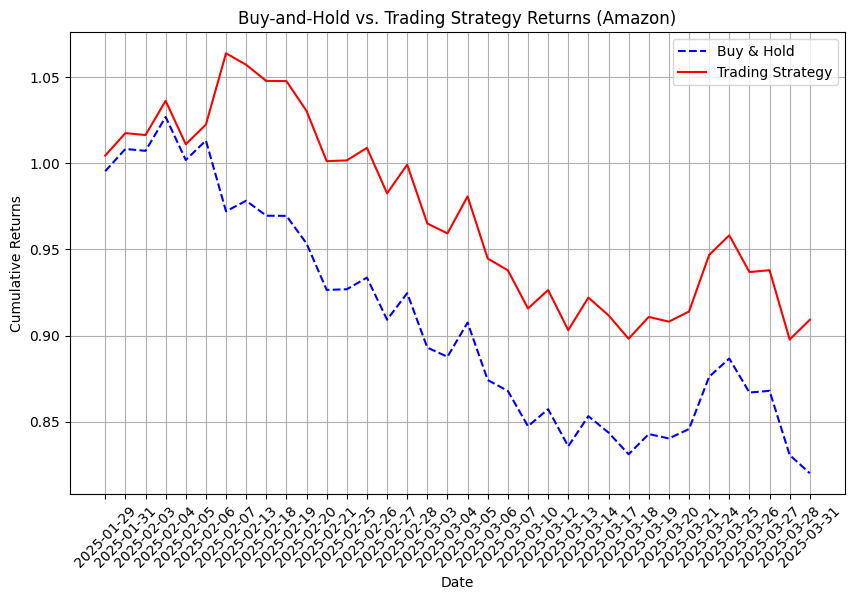

In [38]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot buy-and-hold cumulative returns
plt.plot(
    amazon_backtest["Date"],
    amazon_backtest["buyandhold"],
    label="Buy & Hold",
    linestyle="--",
    color="blue",
)

# Plot strategy cumulative returns
plt.plot(
    amazon_backtest["Date"],
    amazon_backtest["strategy_cumulative"],
    label="Trading Strategy",
    linestyle="-",
    color="red",
)

# Formatting
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Buy-and-Hold vs. Trading Strategy Returns (Amazon)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

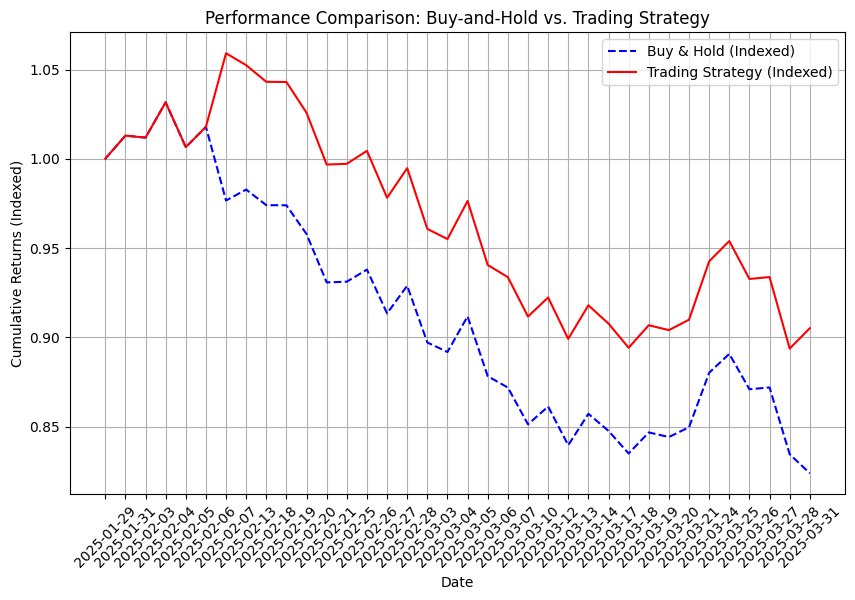

In [39]:
# Normalize buy-and-hold returns to start from 1
amazon_backtest["buyandhold_indexed"] = (
    amazon_backtest["buyandhold"] / amazon_backtest["buyandhold"].iloc[0]
)

# Normalize strategy cumulative returns to start from 1
amazon_backtest["strategy_indexed"] = (
    amazon_backtest["strategy_cumulative"]
    / amazon_backtest["strategy_cumulative"].iloc[0]
)

# Plot indexed returns

plt.figure(figsize=(10, 6))
plt.plot(
    amazon_backtest["Date"],
    amazon_backtest["buyandhold_indexed"],
    label="Buy & Hold (Indexed)",
    linestyle="--",
    color="blue",
)
plt.plot(
    amazon_backtest["Date"],
    amazon_backtest["strategy_indexed"],
    label="Trading Strategy (Indexed)",
    linestyle="-",
    color="red",
)

plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Indexed)")
plt.title("Performance Comparison: Buy-and-Hold vs. Trading Strategy")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [53]:
# Calculate total percentage returns for each strategy
buy_hold_final_return = (amazon_backtest["buyandhold"].iloc[-1] - 1) * 100
strategy_final_return = (
    amazon_backtest["strategy_cumulative"].iloc[-1] - 1
) * 100

# Calculate mean return for each strategy
buy_hold_avg_return = amazon_backtest["buyandhold"].pct_change().mean() * 100
strategy_avg_return = (
    amazon_backtest["strategy_cumulative"].pct_change().mean() * 100
)

# Calculate volatility (standard deviation of returns)
buy_hold_volatility = amazon_backtest["buyandhold"].pct_change().std() * 100
strategy_volatility = (
    amazon_backtest["strategy_cumulative"].pct_change().std() * 100
)

# Calculate max drawdown (largest peak-to-trough decline)
buy_hold_max_drawdown = (
    (amazon_backtest["buyandhold"].max() - amazon_backtest["buyandhold"].min())
    / amazon_backtest["buyandhold"].max()
    * 100
)
strategy_max_drawdown = (
    (
        amazon_backtest["strategy_cumulative"].max()
        - amazon_backtest["strategy_cumulative"].min()
    )
    / amazon_backtest["strategy_cumulative"].max()
    * 100
)

# Create final DataFrame with comparison metrics
amazon_summary_metrics = pd.DataFrame(
    {
        "Metric": [
            "Total Return (%)",
            "Average Daily Return (%)",
            "Volatility (%)",
            "Max Drawdown (%)",
        ],
        "Buy & Hold": [
            buy_hold_final_return,
            buy_hold_avg_return,
            buy_hold_volatility,
            buy_hold_max_drawdown,
        ],
        "Trading Strategy": [
            strategy_final_return,
            strategy_avg_return,
            strategy_volatility,
            strategy_max_drawdown,
        ],
    }
)

amazon_summary_metrics["Asset"] = "Amazon"

# summary metrics
amazon_summary_metrics

,Metric,Buy & Hold,Trading Strategy,Asset
0,Total Return (%),-17.990478,-9.081651,Amazon
1,Average Daily Return (%),-0.532662,-0.264059,Amazon
2,Volatility (%),1.996070,2.050510,Amazon
3,Max Drawdown (%),20.142214,15.620659,Amazon


## Netflix Trading Strategy

In [42]:
# Merge the Pred Data Frame with histdata which contains the level of returns

netflix_returns = merged_sentiment[merged_sentiment["stock"] == "netflix"][
    ["returns", "date"]
]
netflix_returns.rename(columns={"date": "Date"}, inplace=True)

netflix_backtest = df_netflix_strategy.merge(
    netflix_returns, on="Date", how="left"
)

In [43]:
# Buy and hold returns
netflix_backtest["buyandhold"] = (netflix_backtest["returns"] + 1).cumprod()

# Map trade actions to numeric values
netflix_backtest["strategy_multiplier"] = netflix_backtest[
    "Netflix Trade"
].map({"BUY": 1, "SELL": -1})

# Apply strategy returns calculation
netflix_backtest["strategy_return"] = (
    netflix_backtest["strategy_multiplier"] * netflix_backtest["returns"]
)

# Calculate cumulative strategy return
netflix_backtest["strategy_cumulative"] = (
    netflix_backtest["strategy_return"] + 1
).cumprod()

netflix_backtest

,Date,Netflix Trade,returns,buyandhold,strategy_multiplier,strategy_return,strategy_cumulative
0,2025-02-04,BUY,0.016273,1.016273,1,0.016273,1.016273
1,2025-02-05,BUY,0.016324,1.032862,1,0.016324,1.032862
2,2025-02-07,BUY,-0.001723,1.031082,1,-0.001723,1.031082
3,2025-02-10,BUY,0.013482,1.044984,1,0.013482,1.044984
4,2025-02-11,BUY,-0.018996,1.025134,1,-0.018996,1.025134
5,2025-02-12,BUY,0.019076,1.044689,1,0.019076,1.044689
6,2025-02-14,SELL,0.014286,1.059613,-1,-0.014286,1.029765
7,2025-02-18,BUY,-0.021491,1.036841,1,-0.021491,1.007634
8,2025-02-19,BUY,0.007221,1.044329,1,0.007221,1.014910
9,2025-02-20,SELL,-0.018010,1.025521,-1,0.018010,1.033189


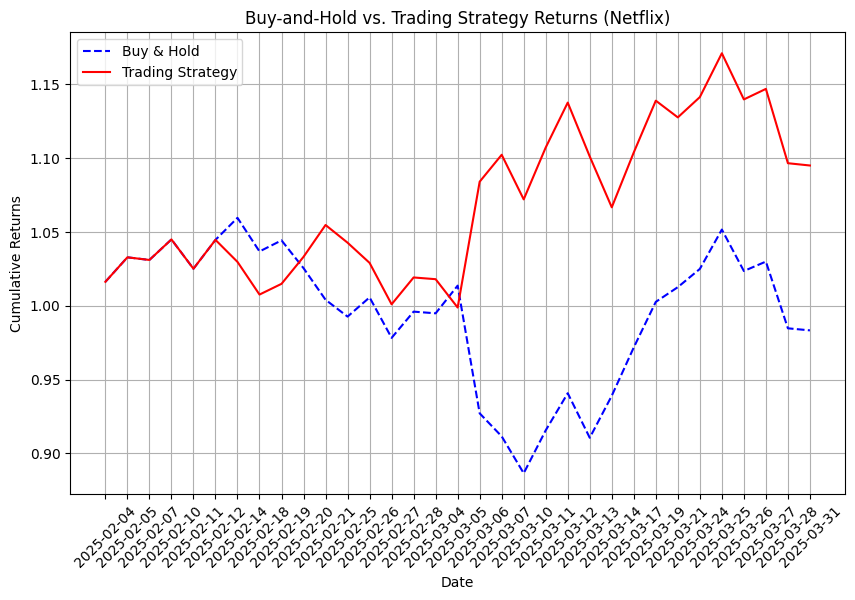

In [44]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot buy-and-hold cumulative returns
plt.plot(
    netflix_backtest["Date"],
    netflix_backtest["buyandhold"],
    label="Buy & Hold",
    linestyle="--",
    color="blue",
)

# Plot strategy cumulative returns
plt.plot(
    netflix_backtest["Date"],
    netflix_backtest["strategy_cumulative"],
    label="Trading Strategy",
    linestyle="-",
    color="red",
)

# Formatting
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Buy-and-Hold vs. Trading Strategy Returns (Netflix)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

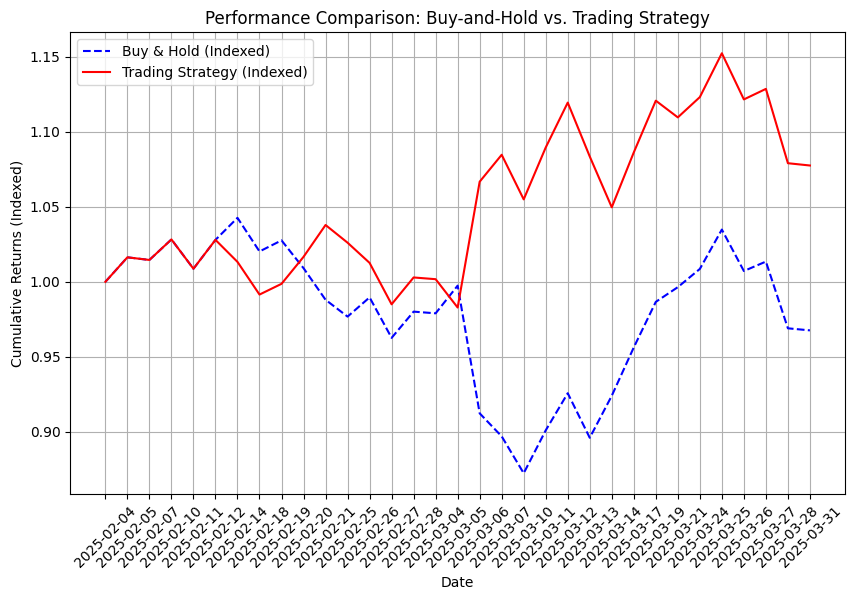

In [45]:
# Normalize buy-and-hold returns to start from 1
netflix_backtest["buyandhold_indexed"] = (
    netflix_backtest["buyandhold"] / netflix_backtest["buyandhold"].iloc[0]
)

# Normalize strategy cumulative returns to start from 1
netflix_backtest["strategy_indexed"] = (
    netflix_backtest["strategy_cumulative"]
    / netflix_backtest["strategy_cumulative"].iloc[0]
)

# Plot indexed returns

plt.figure(figsize=(10, 6))
plt.plot(
    netflix_backtest["Date"],
    netflix_backtest["buyandhold_indexed"],
    label="Buy & Hold (Indexed)",
    linestyle="--",
    color="blue",
)
plt.plot(
    netflix_backtest["Date"],
    netflix_backtest["strategy_indexed"],
    label="Trading Strategy (Indexed)",
    linestyle="-",
    color="red",
)

plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Indexed)")
plt.title("Performance Comparison: Buy-and-Hold vs. Trading Strategy")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [77]:
# Calculate total percentage returns for each strategy
buy_hold_final_return = (netflix_backtest["buyandhold"].iloc[-1] - 1) * 100
strategy_final_return = (
    netflix_backtest["strategy_cumulative"].iloc[-1] - 1
) * 100

# Calculate mean return for each strategy
buy_hold_avg_return = netflix_backtest["buyandhold"].pct_change().mean() * 100
strategy_avg_return = (
    netflix_backtest["strategy_cumulative"].pct_change().mean() * 100
)

# Calculate volatility (standard deviation of returns)
buy_hold_volatility = netflix_backtest["buyandhold"].pct_change().std() * 100
strategy_volatility = (
    netflix_backtest["strategy_cumulative"].pct_change().std() * 100
)

# Calculate max drawdown (largest peak-to-trough decline)
buy_hold_max_drawdown = (
    (
        netflix_backtest["buyandhold"].max()
        - netflix_backtest["buyandhold"].min()
    )
    / netflix_backtest["buyandhold"].max()
    * 100
)
strategy_max_drawdown = (
    (
        netflix_backtest["strategy_cumulative"].max()
        - netflix_backtest["strategy_cumulative"].min()
    )
    / netflix_backtest["strategy_cumulative"].max()
    * 100
)

# Create final DataFrame with comparison metrics
netflix_summary_metrics = pd.DataFrame(
    {
        "Metric": [
            "Total Return (%)",
            "Average Daily Return (%)",
            "Volatility (%)",
            "Max Drawdown (%)",
        ],
        "Buy & Hold": [
            buy_hold_final_return,
            buy_hold_avg_return,
            buy_hold_volatility,
            buy_hold_max_drawdown,
        ],
        "Trading Strategy": [
            strategy_final_return,
            strategy_avg_return,
            strategy_volatility,
            strategy_max_drawdown,
        ],
    }
)

netflix_summary_metrics["Asset"] = "Netflix"

# summary metrics
netflix_summary_metrics

,Metric,Buy & Hold,Trading Strategy,Asset
0,Total Return (%),-1.661892,9.506036,Netflix
1,Average Daily Return (%),-0.067161,0.267738,Netflix
2,Volatility (%),2.685225,2.672282,Netflix
3,Max Drawdown (%),16.328357,14.707903,Netflix


## Summary Plots Amazon & Netflix

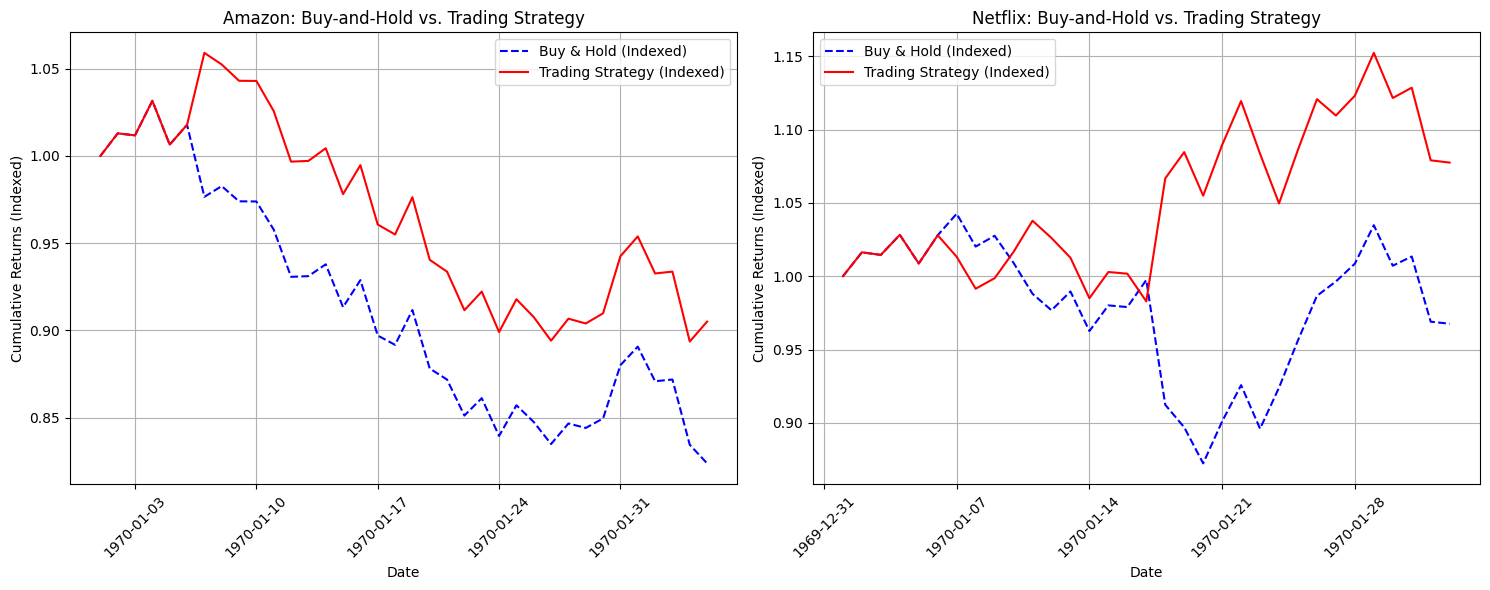

In [66]:
# Create a 1x2 subplot (2 columns, 1 row)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Amazon
axes[0].plot(
    amazon_backtest["Date"],
    amazon_backtest["buyandhold_indexed"],
    label="Buy & Hold (Indexed)",
    linestyle="--",
    color="blue",
)
axes[0].plot(
    amazon_backtest["Date"],
    amazon_backtest["strategy_indexed"],
    label="Trading Strategy (Indexed)",
    linestyle="-",
    color="red",
)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Returns (Indexed)")
axes[0].set_title("Amazon: Buy-and-Hold vs. Trading Strategy")
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis="x", rotation=45)

# Plot for Netflix
axes[1].plot(
    netflix_backtest["Date"],
    netflix_backtest["buyandhold_indexed"],
    label="Buy & Hold (Indexed)",
    linestyle="--",
    color="blue",
)
axes[1].plot(
    netflix_backtest["Date"],
    netflix_backtest["strategy_indexed"],
    label="Trading Strategy (Indexed)",
    linestyle="-",
    color="red",
)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Returns (Indexed)")
axes[1].set_title("Netflix: Buy-and-Hold vs. Trading Strategy")
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis="x", rotation=45)

# Set major ticks to every 7 days (weekly) and format the date labels
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))


# Adjust layout to avoid overlap
plt.tight_layout()

# Save the figure to the images folder
plt.savefig("images/strategy_vs_buyhold.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [87]:
# After calculating amazon_summary_metrics and netflix_summary_metrics:
combined_df = pd.concat(
    [amazon_summary_metrics, netflix_summary_metrics],
    ignore_index=True
).set_index(["Asset", "Metric"])

combined_df = combined_df.round(2)
combined_df

Buy & Hold  Trading Strategy
Asset   Metric                                                
Amazon  Total Return (%)              -17.99             -9.08
        Average Daily Return (%)       -0.53             -0.26
        Volatility (%)                  2.00              2.05
        Max Drawdown (%)               20.14             15.62
Netflix Total Return (%)               -1.66              9.51
        Average Daily Return (%)       -0.07              0.27
        Volatility (%)                  2.69              2.67
        Max Drawdown (%)               16.33             14.71

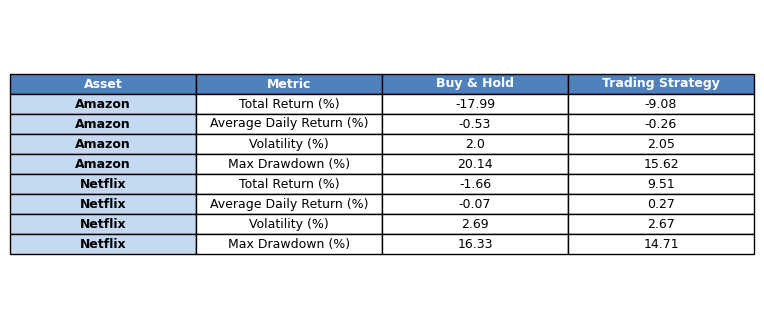

In [104]:
# Convert DataFrame to fig
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis("tight")
ax.axis("off")  # Hide axes

# Create table
table = ax.table(
    cellText=combined_df.reset_index().values,
    colLabels=combined_df.reset_index().columns,
    cellLoc="center",
    loc="center",
)

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(9)  
table.scale(1.2, 1.2)  # Adjust scale to fit text

# Apply styling to headers and asset column
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight="bold", color="white")
        cell.set_facecolor("#4f81bd")  # Dark blue header
    elif j == 0:  # Asset column (Amazon/Netflix)
        cell.set_text_props(weight="bold", color="black")
        cell.set_facecolor("#c5d9f1")  # Light blue asset column

# Save as an image file
plt.savefig("images/strategy_vs_buyhold_table.png", dpi=300, bbox_inches="tight")

# Show the figure (optional)
plt.show()